### Проект: вариант 4
### Задание 1

Представьте, что вы аналитик в компании, которая разрабатывает приложение для обработки и оформления фотографий в формате Stories (например, для дальнейшего экспорта в Instagram Stories).
Был проведен A/B тест: тестовой группе предлагалась новая модель оплаты коллекций шаблонов, контрольной – старая механика
Ваша основная задача: проанализировать итоги эксперимента и решить, нужно ли выкатывать новую модель на остальных пользователей.

В ходе отчета обоснуйте выбор метрик, на которые вы обращаете внимание. Если различия есть, то объясните, с чем они могут быть связаны и являются ли значимыми.

Данные:

**active_users** – информация о пользователях, которые посещали приложение во время эксперимента.

**groups** – разбивка пользователей на контрольную (А) и тестовую (В) группы.

**purchases** – данные о транзакциях (оплатах) пользователей приложения во время эксперимента.

In [2]:
# подгружаем необходимые библиотеки
import pandas as pd
import seaborn as sns
sns.set(
    font_scale=1.2,
    style="whitegrid",
    rc={'figure.figsize':(22,8)}
)
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, mannwhitneyu
from tqdm.auto import tqdm
import statsmodels.api as sm

## 1.Подготовка данных
Для начала загрузим все данные по пользователям, далее проверим тип данных, пропущенные значения (если есть) и посмотрим содержимое.

In [3]:
#подгружаем данные
active_users = pd.read_csv('Проект_4_active_users.csv')
groups = pd.read_csv('Проект_4_groups.csv')
purchases = pd.read_csv('Проект_4_purchases.csv')

In [4]:
active_users

,user_id,country,platform,sex
0,8029,Russia,ios,male
1,1735,Sweden,ios,male
2,7697,Russia,android,male
3,1421,Sweden,android,female
4,1704,Russia,ios,male
...,...,...,...,...
8336,2417,Sweden,ios,female
8337,3755,Russia,ios,male
8338,4594,Sweden,android,female
8339,7430,Sweden,ios,female


In [5]:
print(active_users.dtypes)
print('\n', active_users.isna().sum())

user_id      int64
country     object
platform    object
sex         object
dtype: object

 user_id     0
country     0
platform    0
sex         0
dtype: int64


In [6]:
#проверим нет ли дублированных ID
if active_users.user_id.nunique() == active_users.user_id.count():
    print('OK')
else:
    print('Не OK')

OK


Колонки названы удобно, типы данных соответствуют самим данным,повторных id нет, пропущенных значений нет. Проверим оставшиеся:

In [7]:
groups

,user_id,group
0,9149,B
1,9150,B
2,9151,A
3,9152,B
4,9153,B
...,...,...
74571,1010,B
74572,7785,A
74573,1783,B
74574,1164,A


In [8]:
print(groups.dtypes)
print('\n', groups.isna().sum())


user_id     int64
group      object
dtype: object

 user_id    0
group      0
dtype: int64


In [9]:
if groups.user_id.nunique() == groups.user_id.count():
    print('OK')
else:
    print('Не OK')

OK


In [10]:
purchases

,user_id,revenue
0,4412,1000.0
1,9000,701.0
2,9001,700.0
3,9002,702.0
4,5790,1002.0
...,...,...
536,5648,1908.0
537,2277,1912.0
538,5032,1911.0
539,908,1910.0


In [11]:
#проверка на дублированные ID
if purchases.user_id.nunique() == purchases.user_id.count():
    print('OK')
else:
    print('Не OK')

OK


In [12]:
print(purchases.dtypes)
print('\n', purchases.isna().sum())

user_id      int64
revenue    float64
dtype: object

 user_id    0
revenue    0
dtype: int64


In [13]:
purchases.revenue.min()

207.0

In [14]:
active_users_purchases= purchases.merge(active_users, how='outer', on='user_id').query('revenue > 0')
active_users_purchases.user_id.value_counts().sum()

541

In [15]:
groups.user_id.count()

74576

Так, остался всего 541 пользователь из 74576 в таблице *groups*.  
Это может означать, что есть пользователи которые совершали оплату без входа в приложение.  
Исключим этих пользователей, т.к. они не отвечают требованию о пользовании моделью оплаты в приложении.  
Также интересно что в таблице с разбивкой пользователей значительно больше, может быть разбивка происходила вообще по всем пользователям.

In [16]:
active_users_purchases_gr = active_users_purchases.merge(groups, how='inner', on='user_id')
active_users_purchases_gr

,user_id,revenue,country,platform,sex,group
0,4412,1000.0,Russia,android,female,A
1,9000,701.0,NaN,NaN,NaN,B
2,9001,700.0,NaN,NaN,NaN,B
3,9002,702.0,NaN,NaN,NaN,B
4,5790,1002.0,Sweden,android,male,B
...,...,...,...,...,...,...
536,5648,1908.0,Sweden,android,female,B
537,2277,1912.0,Sweden,ios,female,B
538,5032,1911.0,Sweden,ios,male,B
539,908,1910.0,Sweden,android,male,B


Также нужно проверить есть ли пользователи, которые выполнили требование эксперимента (вошли в приложение, совершили покупку) но не были определены в тестовую/контрольную группу.

In [17]:
if active_users_purchases_gr.group.count().sum() == active_users_purchases.user_id.value_counts().sum():
    print('OK')
else:
    print('NOT OK')

OK


Все хорошо, идем дальше

In [29]:
# Соберём все данные о пользователях ,посещавших приложение во время эксперимента, в единый датафрейм

df = active_users.merge(groups, how='left', on='user_id')
sum_df = df.merge(purchases, how='left', on='user_id')

In [30]:
# Разобьём df на контрольную (А) и тестовую (В) группы

control_gr = sum_df.query('group == "A"')
test_gr = sum_df.query('group == "B"')

## 3. Изучение данных и выбор критерия для проверки результата A/B-тестирования
У нас есть таблица со всеми интересующими нас данными, время взглянуть на разбивку по группам.

Проверим разбиение на группы по полу, платформе, и стране

По полу

<AxesSubplot:xlabel='user_id', ylabel='group'>

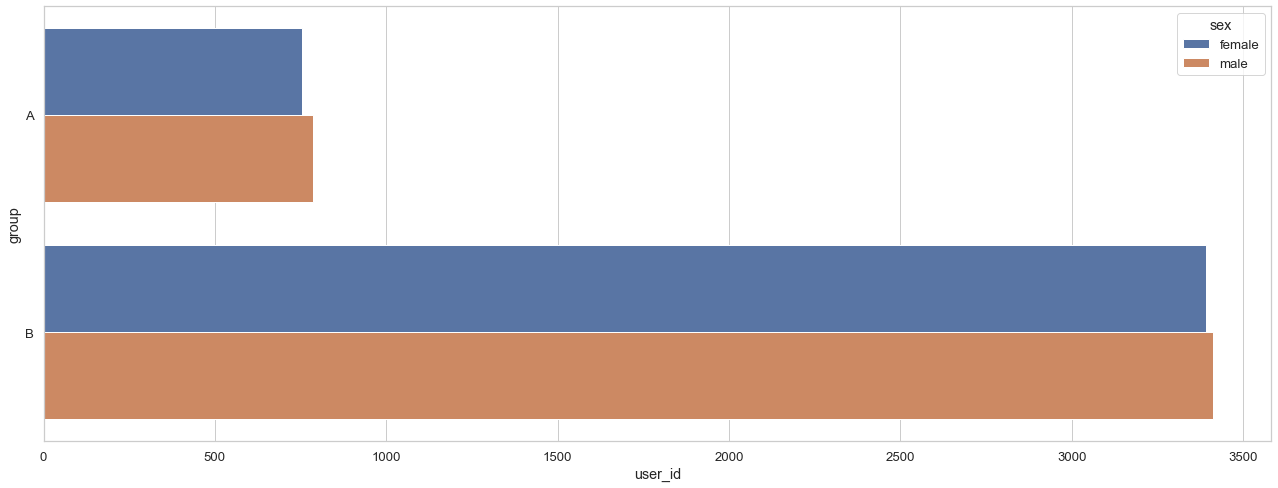

In [20]:
sex = sum_df.groupby(['group', 'sex'], as_index=False).agg({'user_id': 'count'})
sns.barplot(x=sex.user_id, y=sex.group, hue=sex.sex)

По полу все выглядит равномерно

А теперь посмотрим по странам:

<AxesSubplot:xlabel='user_id', ylabel='group'>

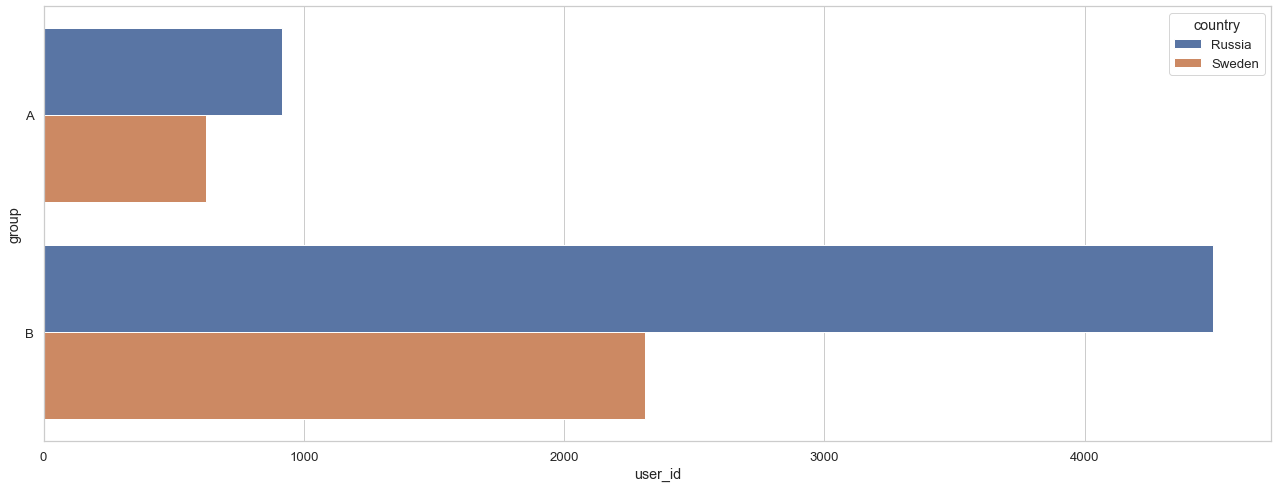

In [21]:
country = df.groupby(['group', 'country'], as_index=False).agg({'user_id': 'count'})
sns.barplot(x=country.user_id, y=country.group, hue=country.country)

In [22]:
sum_df.query('group == "A"')

,user_id,country,platform,sex,group,revenue
8,4038,Russia,android,female,A,NaN
11,2427,Sweden,android,female,A,NaN
22,6772,Sweden,android,female,A,NaN
23,518,Russia,android,female,A,NaN
27,5220,Russia,ios,male,A,NaN
...,...,...,...,...,...,...
8298,3408,Russia,ios,male,A,NaN
8303,4519,Russia,ios,male,A,NaN
8306,7680,Russia,ios,male,A,NaN
8328,7111,Russia,android,male,A,NaN


In [34]:
sum_df.groupby('group').agg({'revenue': 'mean'})

,revenue
group,
A,943.564103
B,1267.875796


In [27]:
active_users_purchases_gr

,user_id,revenue,country,platform,sex,group
0,4412,1000.0,Russia,android,female,A
1,9000,701.0,NaN,NaN,NaN,B
2,9001,700.0,NaN,NaN,NaN,B
3,9002,702.0,NaN,NaN,NaN,B
4,5790,1002.0,Sweden,android,male,B
...,...,...,...,...,...,...
536,5648,1908.0,Sweden,android,female,B
537,2277,1912.0,Sweden,ios,female,B
538,5032,1911.0,Sweden,ios,male,B
539,908,1910.0,Sweden,android,male,B


In [ ]:
#Провести A/A тест?

sum_df.query('group == "A"')

In [ ]:
# проводим А/А тестерирование для всех данных по группам тест/контроль
# в результате FPR > α, следовательно сплитовалка работает некорректно

n = 100000
simulations = 1000
n_s = 1000
res = []

for i in tqdm(range(simulations)):
    s1 = data[data.experimentVariant == 1].purchase.sample(n_s, replace = False).values
    s2 = data[data.experimentVariant == 0].purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) 

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

sum(np.array(res) <0.05) / simulations